In [1]:
import numpy as np
import pickle
from os import listdir
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os 
from random import shuffle

# Loading the Data

In [2]:
import numpy as np
import pandas as pd  
import os 
from sklearn.datasets import load_files

In [3]:
data_dir =  r'C:\Users\Wave\Desktop\Test_vgg16\img\train'
 
data = load_files(data_dir)

# Data Preprocessing and exploring

In [4]:
folders=os.listdir(r'C:\Users\Wave\Desktop\Test_vgg16\img\train')
print(folders)

['chaplu', 'fahthalinejol', 'horapa', 'krapao', 'lemon', 'magrud', 'plu', 'sabtiger', 'saranae', 'yanang']


In [5]:
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
print('Data files - ',X)
print('Target labels - ',y)

Data files -  ['C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\fahthalinejol\\aug_0_1298.jpg'
 'C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\sabtiger\\aug_0_8336.jpg'
 'C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\fahthalinejol\\aug_0_5026.jpg'
 ...
 'C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\krapao\\aug_0_1918.jpg'
 'C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\yanang\\aug_0_372.jpg'
 'C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\horapa\\aug_0_6768.jpg']
Target labels -  [1 7 1 ... 3 9 2]


# Load the images

In [6]:
from keras.preprocessing.image import img_to_array, load_img

def convert_img_to_arr(file_path_list):
    arr = []
    #size=64,64
    img_width, img_height = 128,128
    for file_path in file_path_list:
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        arr.append(img)
        
    return arr
 
X = np.array(convert_img_to_arr(X))
print(X.shape) 
print('First training item : ',X[0])

(10565, 128, 128, 3)
First training item :  [[[105. 164.  44.]
  [ 73. 134.  15.]
  [ 78. 141.  27.]
  ...
  [ 94.  89.  70.]
  [ 99.  94.  65.]
  [ 99.  95.  60.]]

 [[105. 163.  51.]
  [ 81. 139.  29.]
  [ 78. 140.  33.]
  ...
  [131. 120. 102.]
  [135. 125.  98.]
  [136. 127.  96.]]

 [[119. 174.  73.]
  [ 73. 129.  30.]
  [ 80. 138.  38.]
  ...
  [133. 117. 101.]
  [132. 117.  96.]
  [129. 114.  91.]]

 ...

 [[ 85.  96. 114.]
  [ 84.  96. 112.]
  [ 86.  95. 110.]
  ...
  [200. 207. 111.]
  [215. 209. 113.]
  [230. 216. 117.]]

 [[111. 118. 136.]
  [114. 121. 139.]
  [113. 119. 135.]
  ...
  [199. 205. 109.]
  [219. 210. 115.]
  [231. 217. 118.]]

 [[ 95. 100. 119.]
  [101. 107. 123.]
  [ 93.  96. 113.]
  ...
  [196. 201. 107.]
  [217. 209. 111.]
  [227. 213. 114.]]]


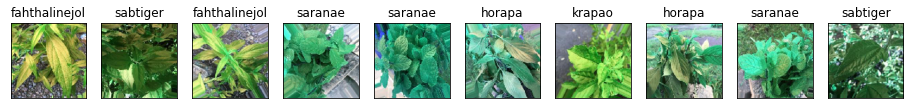

In [7]:
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize = (16,9))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [8]:
X = X.astype('float32')/255
no_of_classes = len(np.unique(y))
no_of_classes

10

# converts a class vector (integers) to binary class matrix

In [9]:
from keras.utils import np_utils
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [10]:
 #80% train, 10% validation, and 10% test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,train_size=0.7,shuffle=True)

X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.15)

In [11]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (128, 128, 3)


# Model

In [12]:
base_model =tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False,input_shape=(128,128,3))

In [13]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']    

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 32, 32, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 16, 16, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
          

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 10, 10, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_blo

 conv4_block3_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block3_2_relu[0][0]']    
                                                                                                  
 conv4_block3_out (Add)         (None, 8, 8, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 8, 8, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 8, 8, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)                                                                                          
          

 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 4, 4, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 max_pooli

 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 4, 4, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

In [14]:
base_model.trainable = False

# Add head

In [15]:
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
prediction_layer = tf.keras.layers.Dense(units=10,activation='softmax')(average_pooling_layer)

In [16]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']         

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 32, 32, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 16, 16, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
          

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 10, 10, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_blo

 conv4_block3_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block3_2_relu[0][0]']    
                                                                                                  
 conv4_block3_out (Add)         (None, 8, 8, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 8, 8, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 8, 8, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)                                                                                          
          

 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 4, 4, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 max_pooli

 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 4, 4, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

# train model

In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), loss="categorical_crossentropy",metrics=["accuracy"])

C:\Users\Wave\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [19]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_valid,y_valid),batch_size=128)

Epoch 1/10
58/58 [==============================] - 193s 3s/step - loss: 0.8680 - accuracy: 0.7634 - val_loss: 0.3655 - val_accuracy: 0.9433
Epoch 2/10
58/58 [==============================] - 173s 3s/step - loss: 0.2618 - accuracy: 0.9509 - val_loss: 0.1916 - val_accuracy: 0.9643
Epoch 3/10
58/58 [==============================] - 174s 3s/step - loss: 0.1381 - accuracy: 0.9799 - val_loss: 0.1320 - val_accuracy: 0.9706
Epoch 4/10
58/58 [==============================] - 170s 3s/step - loss: 0.0857 - accuracy: 0.9882 - val_loss: 0.0923 - val_accuracy: 0.9853
Epoch 5/10
58/58 [==============================] - 172s 3s/step - loss: 0.0576 - accuracy: 0.9930 - val_loss: 0.0705 - val_accuracy: 0.9853
Epoch 6/10
58/58 [==============================] - 170s 3s/step - loss: 0.0402 - accuracy: 0.9966 - val_loss: 0.0578 - val_accuracy: 0.9853
Epoch 7/10
58/58 [==============================] - 170s 3s/step - loss: 0.0295 - accuracy: 0.9980 - val_loss: 0.0485 - val_accuracy: 0.9853
Epoch 8/10
58

In [20]:
(eval_loss, eval_accuracy) = model.evaluate(X_test, y_test, batch_size= 128, verbose=2)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("Loss: {}".format(eval_loss))

22/22 - 58s - loss: 0.0333 - accuracy: 0.9915 - 58s/epoch - 3s/step
Accuracy: 99.15%
Loss: 0.03331916406750679


# Acuuracy and Loss graphs

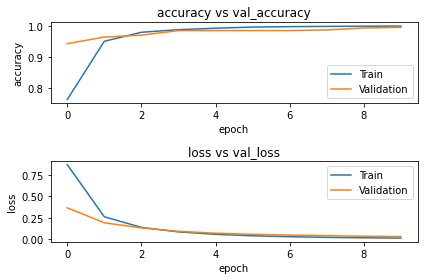

In [21]:
import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1)
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
plot(history)

# Prediction

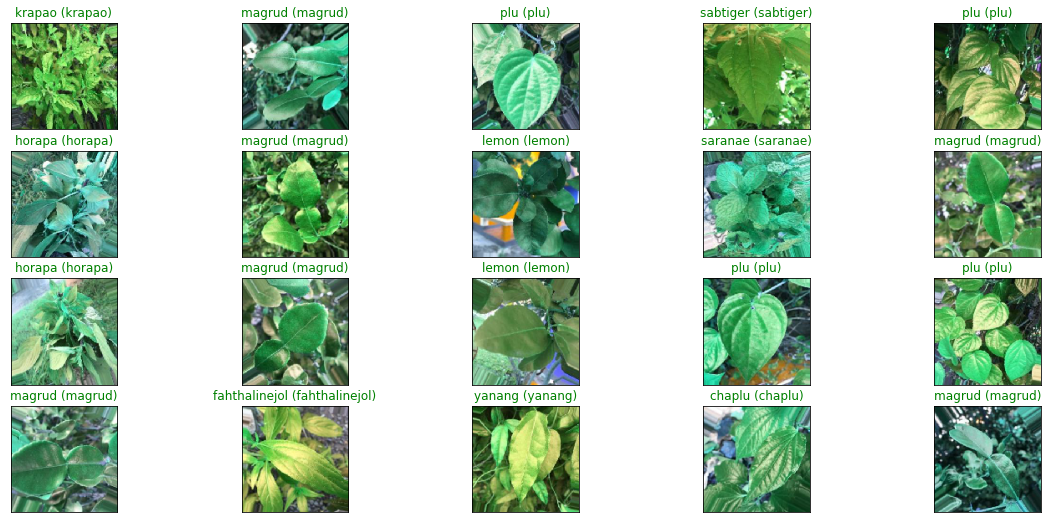

In [22]:
def visualize_pred(y_pred):
    fig = plt.figure(figsize=(20, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

# Confusion matrix

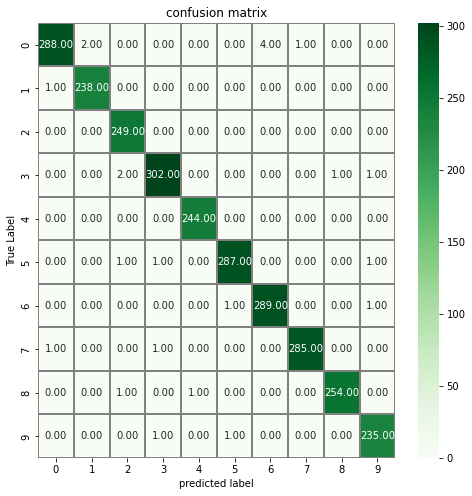

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
print("*******************Confusion matrix*******************")
print(confusion_matrix(Y_true,Y_pred_classes))
print("\n*******************Classification report*******************")
print(classification_report(Y_true,Y_pred_classes))

*******************Confusion matrix*******************
[[288   2   0   0   0   0   4   1   0   0]
 [  1 238   0   0   0   0   0   0   0   0]
 [  0   0 249   0   0   0   0   0   0   0]
 [  0   0   2 302   0   0   0   0   1   1]
 [  0   0   0   0 244   0   0   0   0   0]
 [  0   0   1   1   0 287   0   0   0   1]
 [  0   0   0   0   0   1 289   0   0   1]
 [  1   0   0   1   0   0   0 285   0   0]
 [  0   0   1   0   1   0   0   0 254   0]
 [  0   0   0   1   0   1   0   0   0 235]]

*******************Classification report*******************
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       295
           1       0.99      1.00      0.99       239
           2       0.98      1.00      0.99       249
           3       0.99      0.99      0.99       306
           4       1.00      1.00      1.00       244
           5       0.99      0.99      0.99       290
           6       0.99      0.99      0.99       291
           7       1